# 随机森林回归

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv',index_col=0,header=0)
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv',index_col=0,header=0)
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv',index_col=0,header=0)
mddata = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [23]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return temp

In [24]:
rawdataset = pd.merge(mddata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

In [29]:
x = dataset.iloc[:, 1:-1]
x = np.array(x, dtype = np.float64)
y = dataset.iloc[:, -1]
y = np.array(y, dtype = np.float64)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)
# 3 训练数据和测试数据进行标准化处理
ss_x = StandardScaler()
x_train = ss_x.fit_transform(x_train)
x_test = ss_x.transform(x_test)

ss_y = StandardScaler()
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))


x_train.shape: (270, 1285)
x_test.shape: (90, 1285)
y_train.shape: (270,)
y_test.shape: (90,)


In [36]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 4 三种集成回归模型进行训练和预测
# 随机森林回归
rfr = RandomForestRegressor()
# 训练
rfr.fit(x_train, y_train)
# 预测 保存预测结果
rfr_yte_predict = rfr.predict(x_test)
rfr_ytr_predict = rfr.predict(x_train)
# 极端随机森林回归
etr = ExtraTreesRegressor()
# 训练
etr.fit(x_train, y_train)
# 预测 保存预测结果
etr_yte_predict = rfr.predict(x_test)
etr_ytr_predict = rfr.predict(x_train)
# 梯度提升回归
gbr = GradientBoostingRegressor()
# 训练
gbr.fit(x_train, y_train)
# 预测 保存预测结果
gbr_yte_predict = rfr.predict(x_test)
gbr_ytr_predict = rfr.predict(x_train)

In [37]:
# 5 模型评估
# 随机森林回归模型评估
print("随机森林回归的默认评估值为：", rfr.score(x_test, y_test))
print("随机森林回归的R_squared值为：", r2_score(y_test, rfr_y_predict))
print("随机森林回归的均方误差为:", mean_squared_error(ss_y.inverse_transform(y_test),
                                          ss_y.inverse_transform(rfr_y_predict)))
print("随机森林回归的平均绝对误差为:", mean_absolute_error(ss_y.inverse_transform(y_test),
                                             ss_y.inverse_transform(rfr_y_predict)))

# 极端随机森林回归模型评估
print("极端随机森林回归的默认评估值为：", etr.score(x_test, y_test))
print("极端随机森林回归的R_squared值为：", r2_score(y_test, gbr_y_predict))
print("极端随机森林回归的均方误差为:", mean_squared_error(ss_y.inverse_transform(y_test),
                                            ss_y.inverse_transform(gbr_y_predict)))
print("极端随机森林回归的平均绝对误差为:", mean_absolute_error(ss_y.inverse_transform(y_test),
                                               ss_y.inverse_transform(gbr_y_predict)))

# 梯度提升回归模型评估
print("梯度提升回归回归的默认评估值为：", gbr.score(x_test, y_test))
print("梯度提升回归回归的R_squared值为：", r2_score(y_test, etr_y_predict))
print("梯度提升回归回归的均方误差为:", mean_squared_error(ss_y.inverse_transform(y_test),
                                            ss_y.inverse_transform(etr_y_predict)))
print("梯度提升回归回归的平均绝对误差为:", mean_absolute_error(ss_y.inverse_transform(y_test),
                                               ss_y.inverse_transform(etr_y_predict)))

随机森林回归的默认评估值为： 0.2200139094404252
随机森林回归的R_squared值为： 0.25002773336425665
随机森林回归的均方误差为: 27782237.267857995
随机森林回归的平均绝对误差为: 3114.8190536666666
极端随机森林回归的默认评估值为： 0.22886777017757698
极端随机森林回归的R_squared值为： 0.25002773336425665
极端随机森林回归的均方误差为: 27782237.267857995
极端随机森林回归的平均绝对误差为: 3114.8190536666666
梯度提升回归回归的默认评估值为： 0.29306371170647105
梯度提升回归回归的R_squared值为： 0.25002773336425665
梯度提升回归回归的均方误差为: 27782237.267857995
梯度提升回归回归的平均绝对误差为: 3114.8190536666666


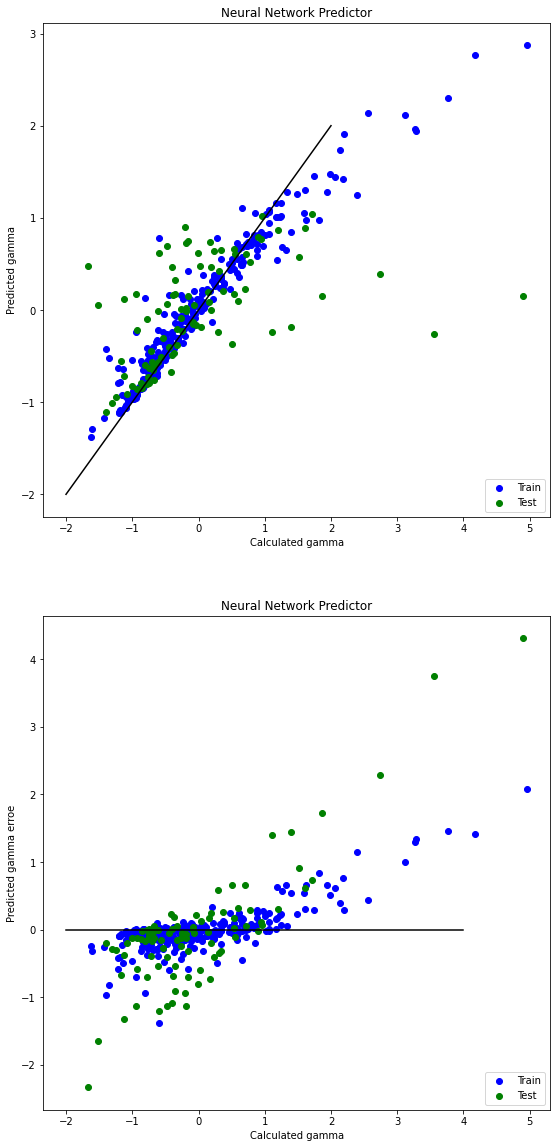

In [38]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.scatter(y_train, rfr_ytr_predict, label = 'Train', c = 'blue')
ax1.scatter(y_test,rfr_yte_predict,c='green', label = 'Test', alpha = None)
ax1.plot([-2,2],[-2,2],c = 'k')
ax1.legend(loc = 4)


ax3 = fig.add_subplot(223)
ax3.set_title('Neural Network Predictor')
ax3.set_xlabel('Calculated gamma')
ax3.set_ylabel('Predicted gamma erroe')
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax3.scatter(y_train,y_train-rfr_ytr_predict, label = 'Train', c = 'blue')
ax3.scatter(y_test,y_test-rfr_y_predict,c='green', label = 'Test', alpha = None)
ax3.plot([-2,4],[0,0],c = 'k')
ax3.legend(loc = 4)

plt.show()